In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance

PARAMETERS = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 

## Relevant functions from utils.py
Can't just import utils since path to data is different than utils.py

In [23]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

## Individual run

In [24]:
data_version=['d1', 'd2'] # 'd1', 'd2'
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true
model_version=['init1', 'init2'] # 'init1' or 'init2'
hmc_run = ['hmc1', 'hmc2'] # 'hmc1' or 'hmc2'

# Parameters (change me!)
idx = 100 # 24 corresponds to 20130221-20130319, the interval in the paper
train_size_fraction = 1.0
hmc_version='v29'
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[0]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[0]}_{model_version[1]}_{hmc_run[0]}"

# Load relevant HMC results
print(f"Comparing {data_bootstrap_model_hmc_identifier_0} and {data_bootstrap_model_hmc_identifier_1} for train size fraction {train_size_fraction}.")
results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"

# Get interval corresponding to one in paper
df = index_mcmc_runs(file_version='2023')
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headers, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

parameter_names = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples.columns = parameter_names
hmc_1_samples.columns = parameter_names

print(hmc_0_samples.head(), len(hmc_0_samples))
print(hmc_1_samples.head(), len(hmc_1_samples))

Comparing d1_b0_init1_hmc1 and d1_b0_init2_hmc1 for train size fraction 1.0.
Interval 20101030-20101126 corresponds to index 100 for neg polarity in PAMELA_H-ApJL2018.
          cpa   pwr1par  pwr1perr   pwr2par  pwr2perr
0  568.962891  0.424405  1.200366  2.264658  0.695122
1  473.077728  1.263795  0.906986  1.684985  1.005980
2  512.440063  0.989457  1.018215  2.272421  0.662462
3  535.631714  0.974568  1.053938  2.120287  0.869661
4  566.069824  0.891094  1.109390  0.672733  0.626926 110000
          cpa   pwr1par  pwr1perr   pwr2par  pwr2perr
0  544.671753  0.962972  1.069418  1.021156  1.006970
1  528.093018  1.599346  0.936106  1.369921  0.647025
2  509.113312  0.598509  1.058617  0.459138  0.767241
3  563.485962  1.060085  1.085887  1.788109  0.530804
4  626.780334  1.121464  1.163501  1.824614  0.517996 110000


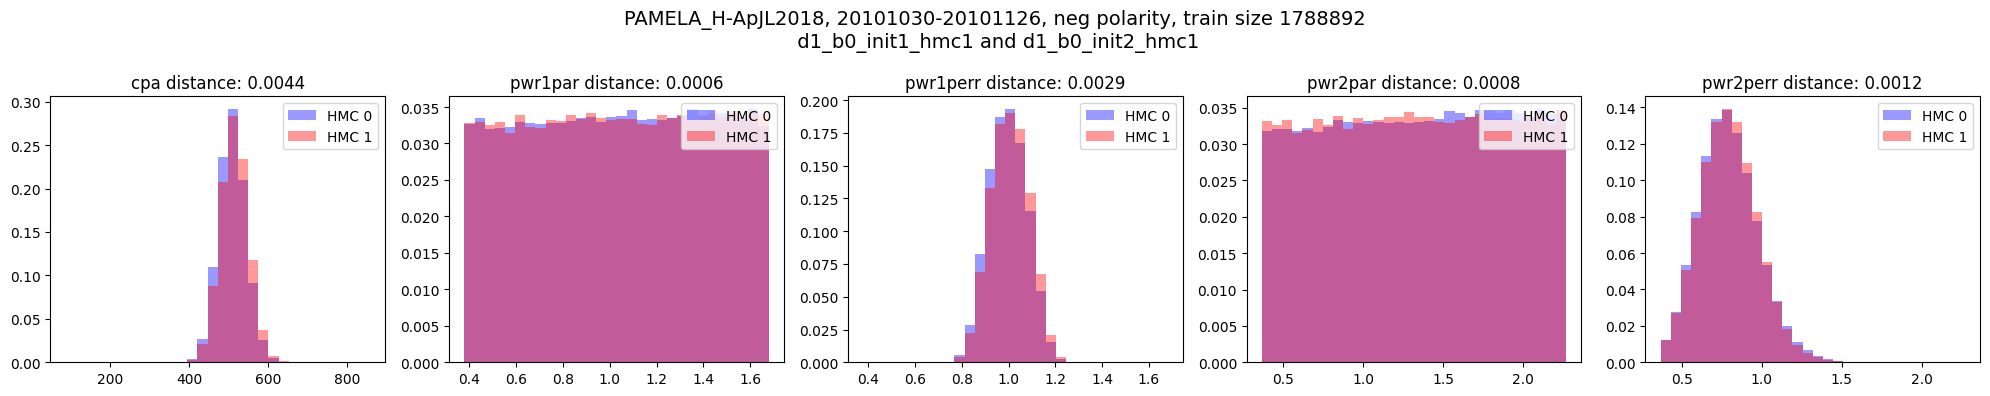

In [25]:
num_bins = 30

# Let's make a 1 x 5 grid of subplots, where they are the historograms of the samples. We'll plot both hmc_0 and hmc_1 samples in the same grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle(f"{exp_name}, {interval}, {polarity} polarity, train size {int(train_size_fraction * 1_788_892)}\n {data_bootstrap_model_hmc_identifier_0} and {data_bootstrap_model_hmc_identifier_1}", fontsize=14)

# Plot the samples
distances = []
for i, param in enumerate(parameter_names):
    samples_0 = hmc_0_samples[param].values
    samples_1 = hmc_1_samples[param].values

    # Plot the samples with same bins
    # Use global binning after lab meeting conversation 4/9/2025
    min = PARAMETERS_MIN[i] 
    max = PARAMETERS_MAX[i]

    # Create histograms and plot
    hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
    hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

    # Normalize the histograms
    hist_0 /= hist_0.sum()
    hist_1 /= hist_1.sum()

    # Compute distance as MAE between bins
    distance = np.abs(hist_0 - hist_1).sum() / num_bins

    # Plot the histograms
    axs[i].bar(bins[:-1], hist_0, width=(bins[1]-bins[0]), alpha=0.4, label='HMC 0', color='blue')
    axs[i].bar(bins[:-1], hist_1, width=(bins[1]-bins[0]), alpha=0.4, label='HMC 1', color='red')

    # Set the title and labels
    axs[i].set_title(f"{param} distance: {distance:.4f}")
    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}_{idx}_samples.png', dpi=300)
plt.show()

## All the train sizes

In [26]:
train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
parameter_names = ['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']
num_bins = 30

distances = {}
for param in parameter_names:
    distances[param] = []

# Calculate the distance for each parameter and train size
for i, train_size_fraction in enumerate(train_fractions):
    # Parameters (change me!)
    results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
    results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"

    # Load the samples from each hmc run
    # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
    # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

    hmc_0_samples.columns = parameter_names
    hmc_1_samples.columns = parameter_names

    for j, param in enumerate(parameter_names):
        samples_0 = hmc_0_samples[param].values
        samples_1 = hmc_1_samples[param].values

        # Plot the samples with same bins
        # Use global binning after lab meeting conversation 4/9/2025
        min = PARAMETERS_MIN[j] 
        max = PARAMETERS_MAX[j]

        # Create histograms and plot
        hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
        hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

        # Normalize the histograms
        hist_0 /= hist_0.sum()
        hist_1 /= hist_1.sum()

        # Calculate distance as MAE between bins
        distance = np.abs(hist_0 - hist_1).sum() / num_bins
        distances[param].append(distance)

FileNotFoundError: [Errno 2] No such file or directory: '../../../results/v29/d1_b0_init1_hmc1_0.0001/samples_100_PAMELA_H-ApJL2018_20101030-20101126_neg.csv'

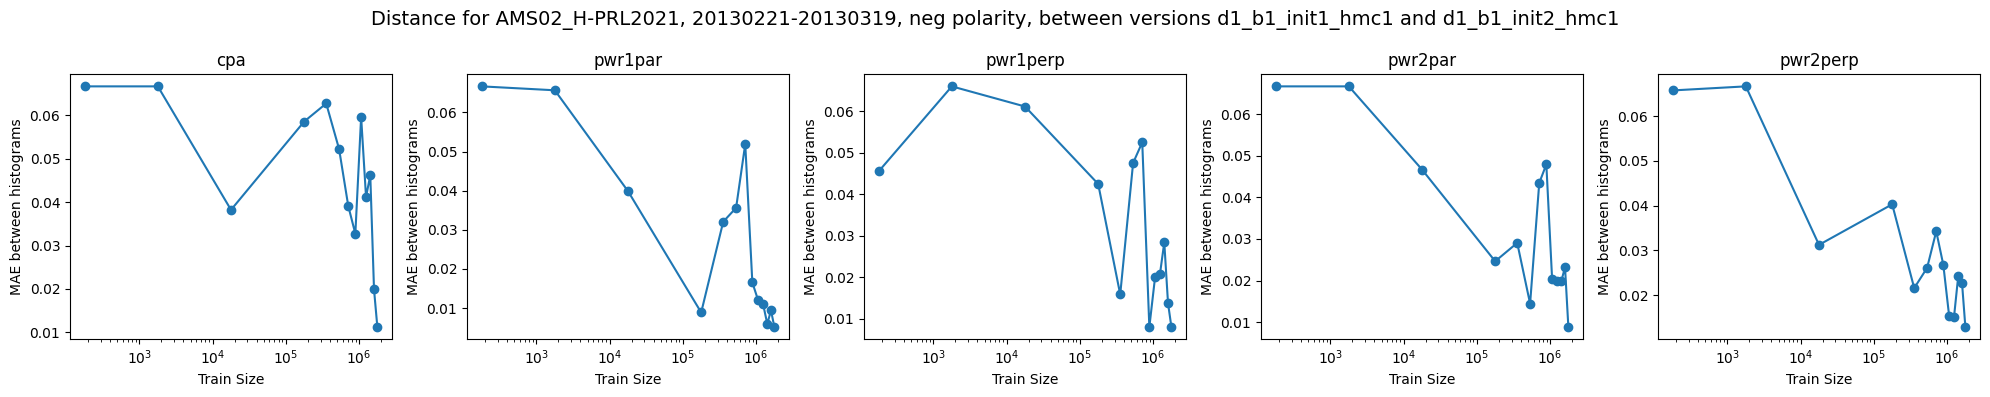

In [ ]:
# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
plt.suptitle(f"Distance for {exp_name}, {interval}, {polarity} polarity, between versions {data_bootstrap_model_hmc_identifier_0} and {data_bootstrap_model_hmc_identifier_1}", fontsize=14)
data_train_fractions = np.array(train_fractions[:-1] + [1.0]) * 1_788_892 # Scale to the number of data points in the full dataset

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    plt.plot(data_train_fractions, distances[param], marker='o')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel('MAE between histograms')
    plt.xscale('log')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_1}_{idx}_mae_distance.png', dpi=300)
plt.show()

## All the runs

In [ ]:
df_idxs = range(len(df))
parameter_names = ['cpa', 'pwr1par', 'pwr1perp', 'pwr2par', 'pwr2perp']
num_bins = 30
train_size_fraction = 1.0

distances = {}
for param in parameter_names:
    distances[param] = []

# Calculate the distance for each parameter and train size
for i, idx in enumerate(df_idxs):
    # Parameters (change me!)
    results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
    results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"

    # Load the samples from each hmc run
    # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
    # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
    exp_name = df.experiment_name.iloc[idx]
    interval = df.interval.iloc[idx]
    polarity = df.polarity.iloc[idx]
    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

    hmc_0_samples.columns = parameter_names
    hmc_1_samples.columns = parameter_names

    for j, param in enumerate(parameter_names):
        samples_0 = hmc_0_samples[param].values
        samples_1 = hmc_1_samples[param].values

        # Plot the samples with same bins
        # Use global binning after lab meeting conversation 4/9/2025
        min = PARAMETERS_MIN[j] 
        max = PARAMETERS_MAX[j]

        # Create histograms and plot
        hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
        hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

        # Normalize the histograms
        hist_0 /= hist_0.sum()
        hist_1 /= hist_1.sum()

        # Calculate distance as MAE between bins
        distance = np.abs(hist_0 - hist_1).sum() / num_bins
        distances[param].append(distance)

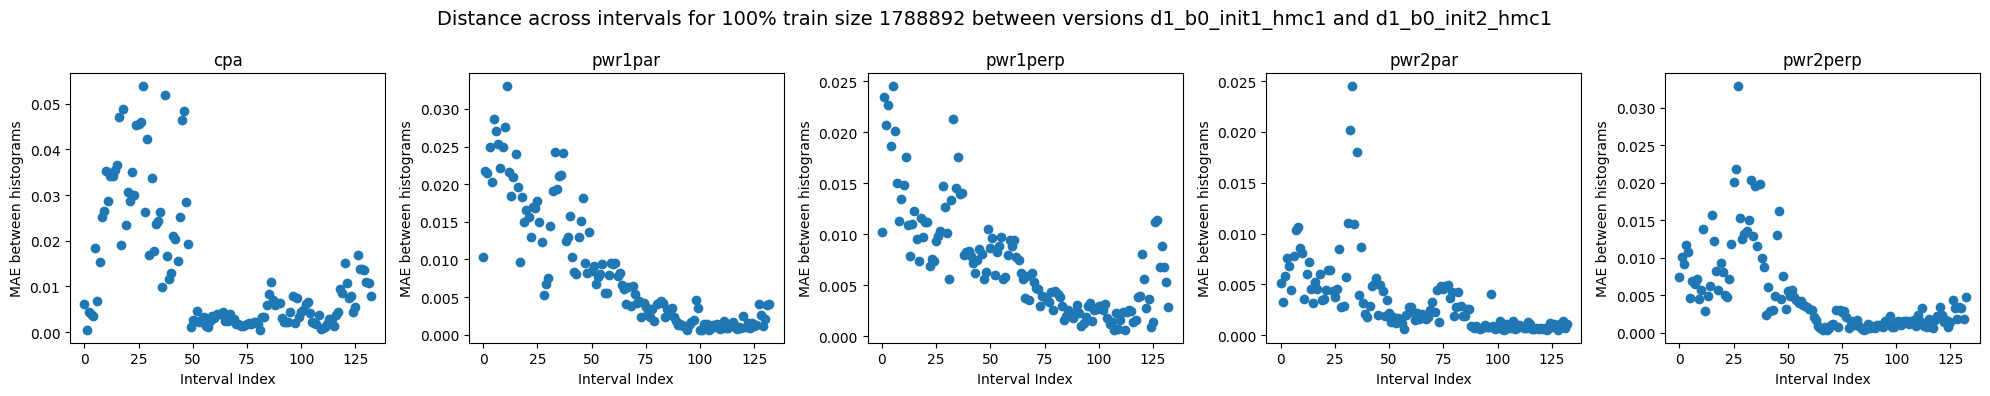

In [31]:
# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
plt.suptitle(f"Distance across intervals for {int(train_size_fraction * 100)}% train size {int(train_size_fraction * 1_788_892)} between versions {data_bootstrap_model_hmc_identifier_0} and {data_bootstrap_model_hmc_identifier_1}", fontsize=14)

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    plt.scatter(df_idxs, distances[param], marker='o')
    plt.title(param)
    plt.xlabel('Interval Index')
    plt.ylabel('MAE between histograms')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}_mae_distance.png', dpi=300)
plt.show()